In [197]:
# Setup plot defaultrialsrialsrialss
import matplotlib.pyplot as plt
import seaborn as sns

# Reset styling to default
plt.rcdefaults()
# Grid on
plt.rcParams['axes.grid'] = True
# Top and right axis spines off
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Title 18 x y labels 16 ticks 14
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
fig_w=6
fig_h=6
plt.rcParams['figure.figsize'] = (fig_w,fig_h )
# Make axis equal
plt.rcParams['axes.axisbelow'] = True 


plt.rcParams['grid.color'] = '0.8'# Grid color

# Set default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#043908', '#ff7f0e', '#9467bd', '#d62728', '#364704', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
# Set default grid settings
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.7
plt.rcParams['font.family'] = 'sans-serif'

### 1- Psychometric function and Negative Log Likelihood functions

In [198]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# psychometric function
# define the psychometric function
def psychometric_function(intensities, lapse_rate,mu, sigma):
    # Compute Φ(intensities; μ, σ) cdf is basically sum of probablity densities 
    # until certain point intensities is the x-axis values 
    cdf = norm.cdf(intensities, loc=mu, scale=sigma) 
    # cdf is the cumulative density function kind of like the integral of the 
    # pdf of the normal distribution so when we take one intenstiy lets say 0.6 it will give us the probability of the value being less than or equal to 0.6
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * cdf # p test at intensity
    return p_test

# number of successes on a given trial number and intensity
def simpsych(lambda_, mu, sigma, intensities, trials):
	intensities = np.array(intensities)
	trials = np.array(trials)
	success_per_intensity = []
	for i in range(len(intensities)):
		p_of_level = psychometric_function(intensities[i], lambda_, mu, sigma)
		success = 0
		for j in range(trials[i]):
			rand_decision = np.random.rand()
			if rand_decision < p_of_level:
				success += 1
		success_per_intensity.append(success)
	return np.array(success_per_intensity)

# Compute log-likelihoods for each candidate mu
def log_likelihood(p_I, B, T): # likelihood of the data given the model
    # p_I is the probablity at given intensity
	# B is the number of successes PMF
	# T total number of trials
    # Add a small epsilon for numerical stability
    epsilon = 1e-9
    p_I = np.clip(p_I, epsilon, 1 - epsilon)
    return B*np.log(p_I)+(T-B)*np.log(1-p_I)

# Negative log-likelihood function (function to estimate the parameters fiting a psychometric)
def negative_log_likelihood(params, delta_dur, chose_test, total_responses):
    lambda_, mu, sigma = params
    p = psychometric_function(delta_dur, lambda_, mu, sigma)
    epsilon = 1e-9  # To prevent log(0)
    p = np.clip(p, epsilon, 1 - epsilon)
    log_likelihood = np.sum(chose_test * np.log(p) + (total_responses - chose_test) * np.log(1 - p))
    return -log_likelihood


# 1 - Fit pilot data to a psychometric function

lambda: 0.2909483600851248, mu: 0.12129779935758364, sigma: 0.21294155066049167
lambda: 0.0, mu: 0.11961921879674374, sigma: 0.500250101993697


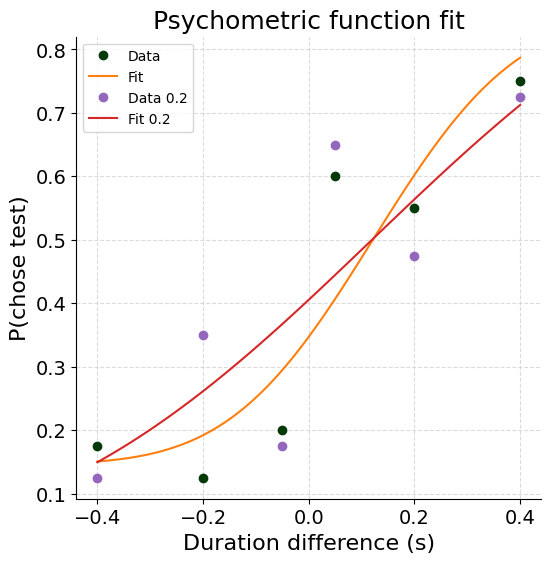

In [199]:
# Fit real data and retrieve initial mu lambda sigma parameters
import pandas as pd
from scipy.optimize import minimize

# Load data
data = pd.read_csv('data/_auditory_dur_estimate_2024-12-09_11h55.43.030.csv')

# Step 1: Prepare the data
data['chose_test'] = (data['response'] == data['test_order']).astype(int)

# Step 2: Group by delta_dur and rise_dur
grouped = data.groupby(['delta_dur', 'rise_dur']).agg(
    total_responses=('response', 'count'),
    chose_test=('chose_test', 'sum')
).reset_index()

# Step 3: Calculate the proportion of "choose test" responses
grouped['p_choose_test'] = grouped['chose_test'] / grouped['total_responses']

# Step 4: Extract data for rise_dur = 0.1 and 0.2
psychometric_data_rise1 = grouped[grouped['rise_dur'] == 0.1][['delta_dur', 'chose_test', 'total_responses']].values
psychometric_data_rise2 = grouped[grouped['rise_dur'] == 0.2][['delta_dur', 'chose_test', 'total_responses']].values

def fit_to_psychometric(data):
    # intensities
    intensities=data[:,0]
    # p(chose)
    chosen_test = data[:,1]
    # total responses on that condition
    total_resp=data[:,2]

    initial_guess = [0.05, 0, 0.1]  # Initial guesses for [lambda, mu, sigma]
    bounds = [(0, 1), (-1, 1), (0.01, 1)]  # lambda ∈ [0,1], mu ∈ [-1,1], sigma > 0

    result = minimize(negative_log_likelihood, initial_guess, 
                      args=(intensities, chosen_test, total_resp), 
                      bounds=bounds)
    lambda_hat, mu_hat, sigma_hat = result.x
    return lambda_hat, mu_hat, sigma_hat
    

lamda_data_fit,mu_data_fit,sigma_data_fit=fit_to_psychometric(psychometric_data_rise1)
print(f'lambda: {lamda_data_fit}, mu: {mu_data_fit}, sigma: {sigma_data_fit}')

lamda_data_fit2,mu_data_fit2,sigma_data_fit2=fit_to_psychometric(psychometric_data_rise2)
print(f'lambda: {lamda_data_fit2}, mu: {mu_data_fit2}, sigma: {sigma_data_fit2}')

# Plot data and fit
plt.figure(figsize=(fig_w,fig_h))
x_fit=np.linspace(min(psychometric_data_rise1[:,0]),max(psychometric_data_rise1[:,0]),100)
y_fit=psychometric_function(x_fit,lamda_data_fit,mu_data_fit,sigma_data_fit)
plt.plot(psychometric_data_rise1[:,0],psychometric_data_rise1[:,1]/psychometric_data_rise1[:,2],'o',label='Data')
plt.plot(x_fit,y_fit,label='Fit')
plt.xlabel('Duration difference (s)')
plt.ylabel('P(chose test)')
plt.title('Psychometric function fit')

x_fit2=np.linspace(min(psychometric_data_rise2[:,0]),max(psychometric_data_rise2[:,0]),100)
y_fit2=psychometric_function(x_fit2,lamda_data_fit2,mu_data_fit2,sigma_data_fit2)
plt.plot(psychometric_data_rise2[:,0],psychometric_data_rise2[:,1]/psychometric_data_rise2[:,2],'o',label='Data 0.2')
plt.plot(x_fit2,y_fit2,label='Fit 0.2')
plt.xlabel('Duration difference (s)')
plt.legend()



### 2- simulation and data fitting

  message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 24.031746881424286
        x: [ 0.000e+00  3.930e-02  1.041e-01]
      nit: 11
      jac: [ 1.032e+01  3.553e-07  3.553e-07]
     nfev: 56
     njev: 14
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>


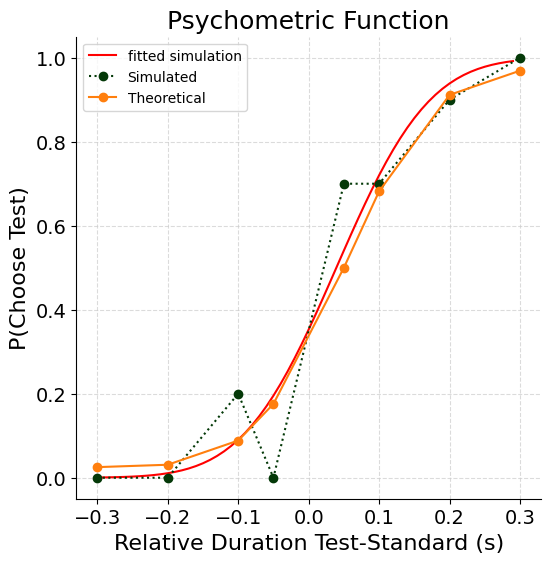

In [200]:

lambda_=0.05
mu=0.05
intensities = np.array([-300,-200, -100, -50, 50, 100, 200,300])/1000  # in ms, stimulus levels
n_trials=10 #n trials per intensity
T=[int(x) for x in np.ones(len(intensities))*n_trials]
sigma=0.1

# simulate the data
simulated_data = simpsych(lambda_,mu,sigma,intensities, T) # simulate the data number of trials for each intensity
psychometric_I=psychometric_function(intensities, lambda_,mu,sigma) # calculate the probablity of test is longer

# fit simulated_data to 
initial_guess=[0.1,0,0.1]
bounds = [(0, 1), (-1, 1), (0.01, 1)]  # Ensure sigma is positive
result = minimize(negative_log_likelihood, initial_guess, args=(intensities, simulated_data, T), bounds=bounds)
print(result)
lambda_fitted,mu_fitted,sigma_fitted = result.x
bias=mu_fitted-mu
rmse_mu=bias**2

x_fit=np.arange(-0.3,0.3,0.01)
fitted_psychometric=psychometric_function(x_fit,lambda_fitted,mu_fitted,sigma_fitted)
plt.plot(x_fit, fitted_psychometric, 'r-', label='fitted simulation')
# plot the data
plt.plot(intensities, np.array(simulated_data)/T, 'o:',label='Simulated')
plt.plot(intensities, psychometric_I, 'o-',label='Theoretical')
plt.xlabel('Relative Duration Test-Standard (s)')
plt.ylabel('P(Choose Test)')
plt.legend()
plt.title('Psychometric Function')
plt.show()


# 3- Try simulations to find best mu and sigma values for the psychometric function

Maximum Likelihood Estimate of mu: 0.11
Maximum Likelihood Estimate of sigma: 0.016


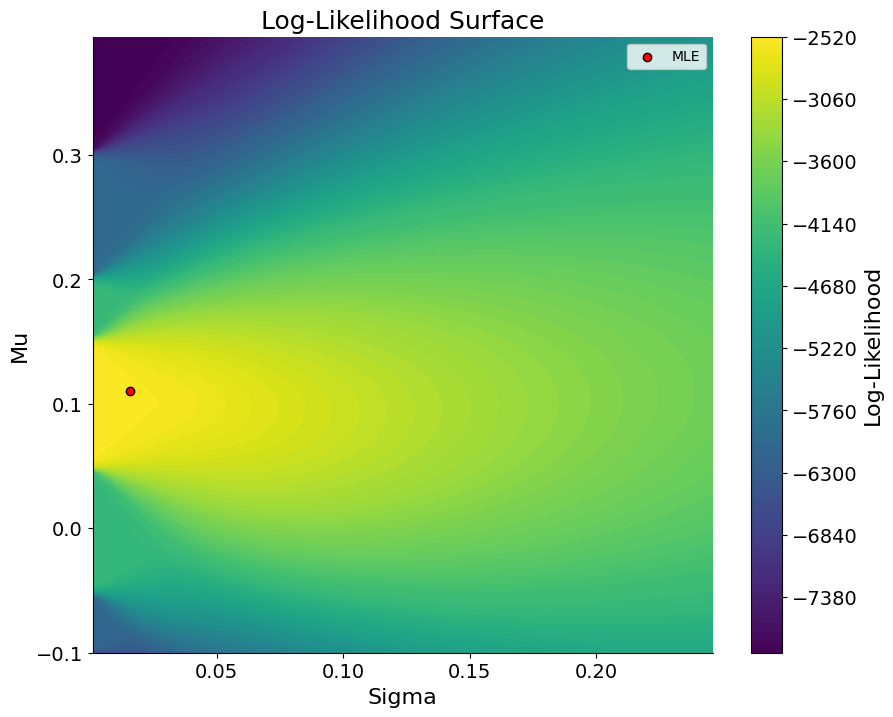

In [201]:
## 3- Try simulations to find best mu and sigma values for the psychometric function
# 3.1- Create a grid of mu and sigma values
# mu should probably be around 0 but a bit more as noise requires to have more cue for the test to be judged as longer
intensities = np.array([-300,-150, -100, -50, 50, 150, 200,300])/1000  # in ms, stimulus levels
T = [1000] * len(intensities)   # Number of trials for each intensity
mu_values=np.arange(-0.1,0.4,0.005)
sigma_values=np.arange(0.001,0.25,0.005)

lambda_prior=0.2
log_likelihood_matrix=np.zeros((len(mu_values),len(sigma_values)))

B=simpsych(lambda_prior,0.1,0.02,intensities,T)

# Compute log-likelihoods for each (mu,sigma) pair
for i,curr_mu in enumerate(mu_values):
    for j,curr_sigma in enumerate(sigma_values):
        p=psychometric_function(intensities,lambda_prior,curr_mu, curr_sigma)
        log_likelihood_matrix[i,j]=np.sum(log_likelihood(p,B,T))


        

# Find the maximum likelihood estimates (MLE) for mu and sigma
max_idx = np.unravel_index(np.argmax(log_likelihood_matrix), log_likelihood_matrix.shape)
mle_mu = mu_values[max_idx[0]]
mle_sigma = sigma_values[max_idx[1]]

print(f"Maximum Likelihood Estimate of mu: {round(mle_mu, 4)}")
print(f"Maximum Likelihood Estimate of sigma: {round(mle_sigma, 4)}")
plt.figure(figsize=(10, 8))
contour = plt.contourf(sigma_values, mu_values, log_likelihood_matrix, levels=100, cmap='viridis')
plt.colorbar(contour, label='Log-Likelihood')
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title('Log-Likelihood Surface')
plt.scatter(mle_sigma, mle_mu, color='red', label='MLE', edgecolor='black')
plt.legend()
plt.show()



### adjust the psychometric with predictions

Maximum Likelihood Estimate of mu: -0.1
Maximum Likelihood Estimate of sigma: 0.091


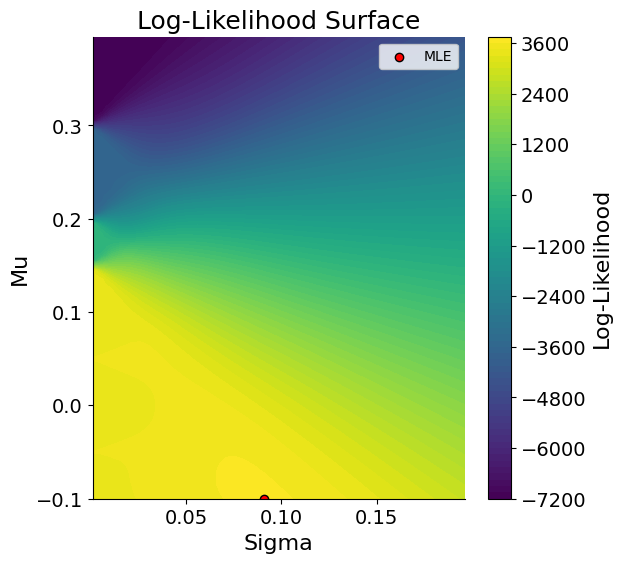

In [202]:
import numpy as np
from scipy.stats import norm

def experiment_model(intensities, lapse_rate, mu, sigma, rise_duration, weight):
    # Compute Φ(intensities; μ, σ) cdf
    cdf = norm.cdf(intensities, loc=mu, scale=sigma)
    # Adjust the probability based on rise_duration and weight
    adjusted_cdf = cdf - weight*rise_duration
    # Ensure the adjusted_cdf is within [0, 1]
    adjusted_cdf = np.clip(adjusted_cdf, 0, 1)
    p_test = lapse_rate * 0.5 + (1 - lapse_rate) * adjusted_cdf
    return p_test

# number of successes on a given trial number and intensity
def modeled_simpsych(lambda_, mu, sigma, intensities, trials, rise_duration, weight):
    intensities = np.array(intensities)
    trials = np.array(trials)
    success_per_intensity = []
    for i in range(len(intensities)):
        p_of_level = experiment_model(intensities[i], lambda_, mu, sigma, rise_duration, weight)
        success = 0
        for j in range(trials[i]):
            rand_decision = np.random.rand()
            if rand_decision < p_of_level:
                success += 1
        success_per_intensity.append(success)
    return np.array(success_per_intensity)

intensities = np.array([-300,-150, -100, -50, 50, 150, 200,300])/1000  # in ms, stimulus levels
T = [200] * len(intensities)   # Number of trials for each intensity
mu_values=np.arange(-0.1,0.4,0.005)
sigma_values=np.arange(0.001,0.2,0.005)

rise_duration=0.02
weight=0.01

lambda_prior=0.2
log_likelihood_matrix=np.zeros((len(mu_values),len(sigma_values)))

# Compute log-likelihoods for each (mu,sigma) pair
for i,curr_mu in enumerate(mu_values):
    for j,curr_sigma in enumerate(sigma_values):
        p=psychometric_function(intensities,lambda_prior,curr_mu, curr_sigma)
        #B=modeled_simpsych(lambda_prior,curr_mu,curr_sigma,intensities,T,rise_duration,weight)
        log_likelihood_matrix[i,j]=np.sum(log_likelihood(p,B,T))


        

# Find the maximum likelihood estimates (MLE) for mu and sigma
max_idx = np.unravel_index(np.argmax(log_likelihood_matrix), log_likelihood_matrix.shape)
mle_mu = mu_values[max_idx[0]]
mle_sigma = sigma_values[max_idx[1]]

print(f"Maximum Likelihood Estimate of mu: {round(mle_mu, 4)}")
print(f"Maximum Likelihood Estimate of sigma: {round(mle_sigma, 4)}")
plt.figure(figsize=(6,6))
contour = plt.contourf(sigma_values, mu_values, log_likelihood_matrix, levels=100, cmap='viridis')
plt.colorbar(contour, label='Log-Likelihood')
plt.xlabel('Sigma')
plt.ylabel('Mu')
plt.title('Log-Likelihood Surface')
plt.scatter(mle_sigma, mle_mu, color='red', label='MLE', edgecolor='black')
plt.legend()
plt.show()




### 5- Run more simulations using the real pilot data fitted parameters to get required number of trials per condition


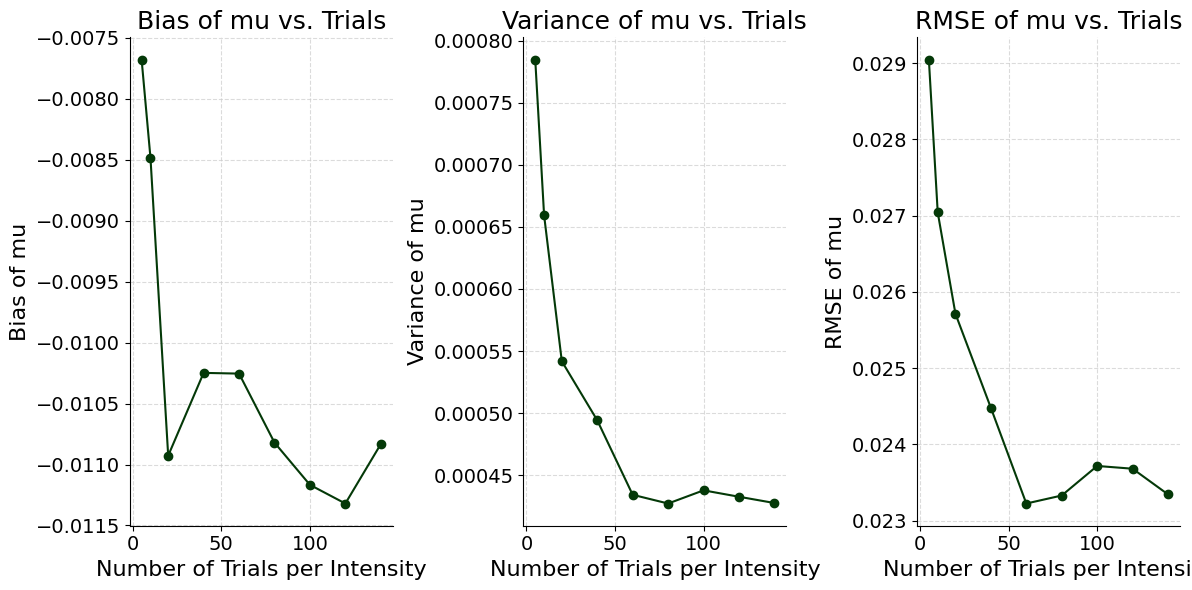

In [ ]:
result_data=fit_to_psychometric(psychometric_data_rise1)
true_lambda=0.15
true_mu=0.01
true_sigma=0.015

intensities = np.array([-200, -100, -50, 50, 100,200])/1000  # in ms, stimulus levels
trial_counts = [5, 10,20,40,60,80,100,120,140]  # Different number of trials to test

n_simulations = 1000  # Number of Monte Carlo simulations for each trial count

results = {'trials': [], 'bias_mu': [], 'var_mu': [], 'rmse_mu': []}

for num_trials in trial_counts:
    biases_mu = []
    variances_mu = []
    rmse_mu_list = []
    for sim in range(n_simulations):
        T = [num_trials] * len(intensities)
        success_per_level = simpsych(true_lambda, true_mu, true_sigma, intensities, T)
        initial_guess = [result_data[0],result_data[1],result_data[2]]  # Initial guess for lambda, mu, sigma
        bounds = [(0, 1), (-1, 1), (0.01, 1)]  # Ensure sigma is positive
        result = minimize(negative_log_likelihood, initial_guess, args=(intensities, success_per_level, T), bounds=bounds)
        lambda_hat, mu_hat, sigma_hat = result.x
        biases_mu.append(mu_hat - true_mu)
        rmse_mu_list.append((mu_hat - true_mu) ** 2)
    bias_mu = np.mean(biases_mu)
    variance_mu = np.var(biases_mu)
    rmse_mu = np.sqrt(np.mean(rmse_mu_list))
    results['trials'].append(num_trials)
    results['bias_mu'].append(bias_mu)
    results['var_mu'].append(variance_mu)
    results['rmse_mu'].append(rmse_mu)

# Plot the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(results['trials'], results['bias_mu'], 'o-')
plt.xlabel('Number of Trials per Intensity')
plt.ylabel('Bias of mu')
plt.title('Bias of mu vs. Trials')

plt.subplot(1, 3, 2)
plt.plot(results['trials'], results['var_mu'], 'o-')
plt.xlabel('Number of Trials per Intensity')
plt.ylabel('Variance of mu')
plt.title('Variance of mu vs. Trials')

plt.subplot(1, 3, 3)
plt.plot(results['trials'], results['rmse_mu'], 'o-')
plt.xlabel('Number of Trials per Intensity')
plt.ylabel('RMSE of mu')
plt.title('RMSE of mu vs. Trials')

plt.tight_layout()
plt.show()
